# Import libraries

In [1]:
import math
import sys
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV

/Users/javiermorlet/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Solve Problem

The Non linear programming problem to solve is


$ \max \left[ (x_{1}^{0.6} + x_{2}^{0.6} + 2 \, x_{1}) - 4 \, x_{3} \right] $

st.

$ -3 \, x_{1} + x_{2}^2 - 3 \, x_{3} = 0 $

$ x_{1} + 9 \, \sqrt{x_{2}} <= 25 $

$ x_{1} + 9 \, \sqrt{x_{3}} <= 25 $

The problem is divided in three parts, the equality constrains, the inequality constrains, and the objective function

## Equality Constrains

The equality constrains consists of solving a system of equations. In this case, we only have one equation and three variables, so we solve for $x_{3}$

In [2]:
def Equations(X, *args):
    
    x1 = X[0]
    x2 = args[0]
    x3 = args[1]
    
    Func = np.empty((1))
    
    Func[0] = -3*x1 + x2**2 - 3*x3
    
    return Func
    

In [3]:
def NLP_eq(X):
    
    x1 = X[0]
    x2 = X[1]
    x3_0 = X[2]
    
    x3 = fsolve(Equations, (x3_0), args=(x1, x2))[0]
    
    return [x1, x2, x3]

## Inequality Constrains

Once the system of equality constrains is solved, the inequality constrains are reviewed to verify they all check. If all check, the varaible feas equals one, and the other case is set equal to zero.

In [4]:
def NLP_in(X):
    
    x1 = X[0]
    x2 = X[1]
    x3 = X[2]

    Res = np.empty((8))
    
    Res[0] = x1 + 9*np.sqrt(x3) <= 25
    Res[1] = x1 + 9*np.sqrt(x2) <= 25

    Res[2] = x1 >= 0
    Res[3] = x2 >= 0
    Res[4] = x3 >= 0

    Res[5] = x1 <= 10
    Res[6] = x2 <= 10
    Res[7] = x3 <= 10

    if Res[0] and Res[1] and Res[2] and Res[3] and Res[4] and Res[5] and Res[6] and Res[7]:
        feas = 1
    else:
        feas = 0
        
    return feas

## Objective function

This function returns the value of the objective function. It returns the minimum value that float can represent if there is no real/determinate solution.

In [5]:
def NLP_obj(X):
    
    x1 = X[0]
    x2 = X[1]
    x3 = X[2]
    
    z0 = (x1**0.6 + x2**0.6 + 2*x1) - 4*x3
    
    if isinstance(z0, complex) or math.isnan(z0):
        z = sys.float_info.min
    else:
        z = z0
        
    return z

## Integrate

Here, we put all the parts of the NLP problem in one function. The function takes the variables as inputs, and returns the varables solved, the feasibility of the problem, and the objective function

In [6]:
def NLP(X0):
    
    X = NLP_eq(X0)
    feas = NLP_in(X)
    z =  NLP_obj(X)
    
    return feas, z, X

# Create Database

The database is created, by solving iteratevly the NLP problem given some variables sampling. The results are stored in a numpy array called Data. The first colum stores the value of the feasibility of the problem, the second the value of the objective function, and the rest the value of the continuos variables.

In [7]:
def Create_Data(X0, n_vars):

    Data = []
    
    for i in range(X0.shape[0]):
        
        if i == 0:
            X = np.zeros(n_vars)

        X0[i,-1] = X[-1]
        feas, z, X = NLP(X0[i,:])
        Data.append(np.concatenate((np.array([feas, z]), np.array(X))).tolist())

    return np.array(Data)

In [8]:
X0 = []

x3 = 0

for x1 in np.linspace(0, 10, 15):
    for x2 in np.linspace(0, 10, 15):
        X0.append((x1, x2, x3))

X0 = np.array(X0)

In [10]:
n_vars = 3
Data = Create_Data(X0, n_vars)

/var/folders/r8/39l5fwnj4wg5s8cbqcdmdj2h0000gn/T/ipykernel_14042/4233216247.py:9: RuntimeWarning: invalid value encountered in sqrt
  Res[0] = x1 + 9*np.sqrt(x3) <= 25


# Data preprocessing

In this section, the database is prepocesed. The fisrt colum is stored as y_clas, the second as z_clas, and the rest as Vars_clas.

In [12]:
y_data = Data[:, 0]
z_data = Data[:, 1]
Vars_data = Data[:, 2:]
all_classes = np.unique(y_data)

We use two scalers, MinMaxScaler for the objective function, and StandardScaler for the variables. Moreover, the variables are reduced using Principal Component Analysis, altough other techniques will be explored.

In [13]:
scaler_minmax = MinMaxScaler()
scaler_std = StandardScaler()

## Dimensionality reduction

In [15]:
clf_red = PCA(n_components=0.95)

In [19]:
def Vars_prep(Vars, scaler, reducer):
    
    Vars_scaled = scaler.fit_transform(Vars)
    
    return reducer.fit_transform(Vars_scaled)

In [20]:
Vars_red = Vars_prep(Vars_data, scaler_std, clf_red)
dim_pca = clf_red.n_components_

Once the variables are scaled, we create three databases

* Clasification Database (Data_clas): The same as Data, but with the variables reduced and scaled
* Regresion Database (Data_reg): Take the points where there is solution of the NLP problem, and scale the objective function (z_reg)
* Clustering Database (Data_clust): The Regresion Database is split in two, the Data_feas where the NLP inequalities are met, and Data_infeas where the inequality constraints do not hold. 

Also, two other databases are created, Data_infeas with all the points where there is no solution or the inequalities does not hold, and Data_feas whith all the feasible solutions.
We also know the solution, so we store it as Data_opt

## Clasification Database

In [13]:
Data_clas = np.concatenate((y_data.reshape(-1,1), z_data.reshape(-1,1), Vars_red), axis=1)

In [14]:
y_clas = Data_clas[:, 0]
z_clas = Data_clas[:, 1]
Vars_clas = Data_clas[:, 2:]

In [15]:
X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(Vars_clas, y_clas, test_size=0.25)

In [16]:
Data_infeas = Data_clas[Data_clas[:, 0] == 0][:, 1:]

## Regresion Database

First, the datas where there in not solution are segregated. Then, the objective function (z_reg) is scaled. 

In [17]:
Data_intractable = Data_clas[Data_clas[:, 1] != sys.float_info.min]

In [18]:
y_reg = Data_intractable[:, 0]
z_reg = Data_intractable[:, 1]
Vars_reg = Data_intractable[:, 2:]

In [19]:
z_scaled = scaler_minmax.fit_transform(np.array(z_reg).reshape(-1,1))

In [20]:
Data_reg = np.concatenate((y_reg.reshape(-1,1), z_scaled.reshape(-1,1), Vars_reg), axis=1)

In [21]:
X_train_reg, X_test_reg, z_train_reg, z_test_reg = train_test_split(Vars_reg, z_scaled, test_size=0.25)

## Clustering Database

In this step, the Data_feas and Data_infeas databases are created to keep track of all points. From the Data_feas database take the reduced and scaled variables for the clustering step

In [22]:
Data_feas = Data_reg[Data_reg[:, 0] == 1][:, 1:]

In [23]:
z_clust = Data_feas[:, 0]
Vars_clust = Data_feas[:, 1:]

In [24]:
X_train_clust, X_test_clust, z_train_clust, z_test_clust = train_test_split(Vars_clust, z_clust, test_size=0.25)

## Optimal Value

In [25]:
x1_opt = 6.2625
x2_opt = 4.3345
x3_opt = 0
z_opt = NLP_obj([x1_opt, x2_opt, x3_opt])

In [26]:
var_opt = np.array([x1_opt, x2_opt, x3_opt]).reshape(1,-1)
var_opt_scaled = scaler_std.transform(var_opt)
var_opt_red = clf_red.transform(var_opt_scaled)
z_opt_red = scaler_minmax.transform(np.array(z_opt).reshape(-1,1))

# Training and Evaluation

In this section, a regression, clasification and clustering algorithms are trained and tested. 
The regression and clasification methods are trained with partial fit, and the clustering with Gaussian Mixtures

## Regression

In [28]:
clf_reg = SGDRegressor()

In [29]:
clf_reg.fit(X_train_reg, z_train_reg.ravel())

SGDRegressor()

In [30]:
clf_reg.score(X_test_reg, z_test_reg)

0.9651377539049901

## Clasification

In [31]:
clf_class = GaussianNB()

In [32]:
clf_class.partial_fit(X_train_clas, y_train_clas, all_classes)

GaussianNB()

In [33]:
clf_class.score(X_test_clas, y_test_clas)

0.9824561403508771

## Clustering

A Gaussian mixture model (GMM) is a probabilistic model that assumes that the data is generated from a mixture of multiple Gaussian distributions. A Gaussian distribution, also known as a normal distribution, defined by two parameters: the mean (average) and the standard deviation.

A GMM is a way of modeling data that is composed of multiple Gaussian distributions. In a GMM, each Gaussian distribution is called a component, and the mixture of these components represents the probability density function of the data. The GMM assigns a weight to each component, which represents the probability that a data point was generated by that componen. [ChatGPT]

In [34]:
gmm = GaussianMixture(n_components=1, covariance_type="full")

In [35]:
gmm.fit(X_train_clust)

GaussianMixture()

# Search of optima

## Functions

Since we have a GMM that assumes data is generated from a mixture of multiple Gaussian distributions, we can generate a confidence interval. A confidence region is a is a set of points in an n-dimensional space, often represented as an ellipsoid around a point satisfying

$ (x - \mu)^{T} \,\Sigma^{-1} \, (x - \mu) \leq \chi_{p, \alpha}^{2} $

The boundary of the set is described by the parametric curve

$ x(\theta) = \mu + \sqrt{(\chi_{p, \alpha}^{2})} \, L \, \Theta $

Where $L$ is the Cholesky factorization of $\Sigma$, and $\Theta$ is a vector of the parameters representation. For the bivariare case

$ \Theta = \left[ \begin{array}{c} 
cos \theta \\
sin \theta
\end{array} \right] \, ; \,  0 < \theta < 2 \pi $

In [36]:
def Paramatric_curve(mu, L, theta, n_std):
    
    xp = mu + np.sqrt(n_std)*np.dot(L,[np.cos(theta), np.sin(theta)])
    
    return xp

Create ellipse given n_std
Returns the points of the boundary of an ellipse in an interval and the interval

In [42]:
def Ellipse(mu, L, Angle, n_std, points):
    
    Data_std = []
    

    for i in range(Angle.shape[0]):
        for theta in np.linspace(Angle[0][i], Angle[1][i], points):
            Data_std.append(np.append(Paramatric_curve(mu, L, theta, n_std), [theta]))

    return np.array(Data_std)

In [39]:
def max_scaled(X, interpol):
    
    x_min = np.amin(X)
    x_max = np.amax(X)
    p_max = np.argmax(X)
    
    return (x_max - x_min)*interpol + x_min

In [40]:
def opt_theta(Z, Theta):
    
    New_theta = []
    A = np.hstack((Z, Theta))
    zmim = np.amin(A[:,0])
    zmax = np.amax(A[:,0])
    pmax = np.argmax(A[:,0])
    zint = (zmax-zmim)*0.75 + zmim
    
    if pmax == 0:
        A_half = A[pmax:,:]
        P_up = np.argmin(A_half[:,0])
        P1 = A_half[P_up, :]
        P2 = A[0,:]
        Temp = (P2[1:] - P1[1:])*((zint-P1[0])/(P2[0]-P1[0])) + P1[1:]
        New_theta.append(np.array(P2))
        New_theta.append(Temp)
    elif pmax == A.shape[0]:
        A_half = A[:pmax+1,:]
        P_down = np.argmax(A_half[:,pmax])
        P1 = A[0,:]
        P2 = A_half[P_down, :]
        Temp = (P2[1:] - P1[1:])*((zint-P1[0])/(P2[0]-P1[0])) + P1[1:]
        New_theta.append(Temp)
        New_theta.append(np.array(P1))
#        New_theta = np.array([Temp, np.array(P1)])
    else:
        for i in range(2):
            if i == 0:
                A_half = A[:pmax+1,:]
            elif i == 1:
                A_half = A[pmax:,:]

            A_up = A_half[A_half[:,0] > zint]
            if A_up.size == 0:
                P_up = np.argmin(A_half[:,0])
                P1 = A_half[P_up, :]
            else:
                P_up = np.argmin(A_up[:,0])
                P1 = A_up[P_up, :]

            A_down = A_half[A_half[:,0] < zint]
            if A_down.size == 0:
                P_down = np.argmax(A_half[:,0])
                P2 = A_half[P_down, :]
            else:
                P_down = np.argmax(A_down[:,0])
                P2 = A_down[P_down, :]
            Temp = (P2[1:] - P1[1:])*((zint-P1[0])/(P2[0]-P1[0])) + P1[1:]
            New_theta.append(Temp)
    
    return New_theta

In [ ]:
def lower_limit(mu, L, Angle, Vars, points, eps, z_max_scaled): 

    log_ll_clust = -gmm.score(Vars)
    
    # Compute n_std_min
    for i in range(points):
        
        Data_std = Ellipse(mu, L, Angle, n_std, 30)
        z_std = clf_reg.predict(Data_std[:, 0:dim_pca])

        if -gmm.score(Data_std[:, 0:dim_pca]) > log_ll_clust or max(z_std) > z_max_scaled or i == 20:
            n_std_min = n_std
            break

        n_std += eps

    return n_std_min

In [ ]:
def uper_limit(mu, L, Angle, points, eps):

    for i in range(points):

        Data_std = Ellipse(mu, L, Angle, n_std, 30)
        
        Data_std_feas = Data_std[clf_class.predict(Data_std[:, 0:dim_pca]) == 1]

        if Data_std_feas.shape[0] == 0 or i == points-1:
            n_std_max = n_std
            break
    
    n_std += eps

    return n_std_max

## Cycle

0.7647244493574316 [[0.82179118]]


TypeError: NLP() takes 1 positional argument but 3 were given

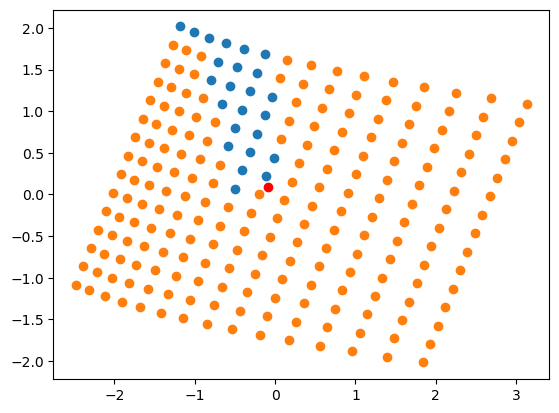

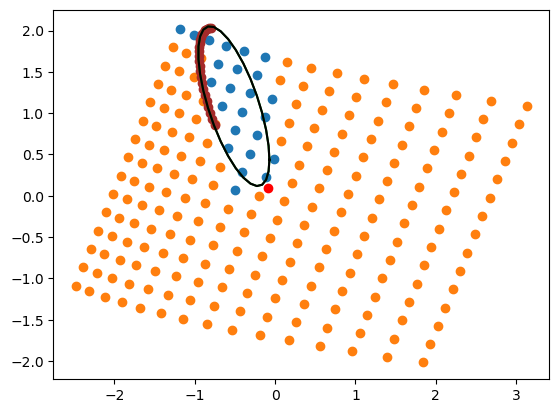

In [43]:
epoch_max = 5
ite_max = 10
Angle = [0, 2*np.pi]

for epoch in range(epoch_max):
    
    plt.figure()
    
    plt.scatter(Data_feas[:,1], Data_feas[:,2])
    plt.scatter(Data_infeas[:,1], Data_infeas[:,2])
    plt.scatter(var_opt_red[0][0], var_opt_red[0][1], c="red")
    
    # Assign:
    n_std = 1
    flag_n_std_min = 1
    flag_n_std_max = 1
    flag_ite = 1
    Data_chunk = []
    
    # Compute μ, Σ, and L
    mu = gmm.means_[0]
    sigma = gmm.covariances_
    L = np.linalg.cholesky(sigma)
    
    # Compute: 
    z_max = max(Data_feas[:,0])
    z_max_scaled = max_scaled(Data_feas[:,0], 0.95)
    
    for ite in range(ite_max):
        
        count = 0
        eps_std = 0.1
        
        if flag_ite == 0:
            flag_ite = 1
            break
            
        if flag_n_std_min == 1:

            # Compute  n_std_max
            n_std_min = lower_limit(Vars_clust, 20, eps_std)

        if flag_n_std_max == 1:
            
            # Compute  n_std_max
            n_std_max = uper_limit(30, eps_std)

        for n_std in np.linspace(n_std_min, n_std_max, 10):
            
            count += 1

            # Create ellipse given n_std
            Data_std = Ellipse(mu, L, Angle, n_std, 30)
            
            # Data_std_feas
            Data_std_feas = Data_std[clf_class.predict(Data_std[:, 0:dim_pca]) == 1]

            if Data_std_feas.shape[0] == 0:
                print('Esc : No feasible sol ellipse')
                n_std = n_std_min
                n_std_min = n_std_min/10
                flag_n_std_min = 0
                break
            
            z_sample = clf_reg.predict(Data_std_feas[:, 0:dim_pca])
            Angle_sample = Data_std_feas[:, dim_pca:]
            
            # New theta
            if Angle_sample.size == 1:
                New_theta = np.array([Angle_sample[0] - 0.1, Angle_sample[0] + 0.1])
            elif Angle_sample.size == 2:
                New_theta = Angle_sample
            else:
                New_theta = opt_theta(z_sample.reshape(-1,1), Angle_sample)

            # Data_search
            Data_search = Ellipse(mu, L, [New_theta[0][0],New_theta[1][0]], n_std, 30)
            
            # Data_search_feas
            Data_search_feas = Data_search[clf_class.predict(Data_search[:, 0:dim_pca]) == 1]
            Vars_search = Data_search_feas[:,0:dim_pca]
            z_search = clf_reg.predict(Vars_search)

            plt.scatter(Vars_search[:,0], Vars_search[:,1], c="brown")
            print(z_max, z_opt_red)

            # Var_search_decom and Vars_search_decaled
            Var_search_decom = clf_red.inverse_transform(Vars_search)
            Vars_search_decaled = scaler_std.inverse_transform(Var_search_decom)
            
            Data_new = Create_Data(Vars_search_decaled, n_vars)

            # y_chunk
            y_data_new = Data_new[:, 0]
            z_data_new = Data_new[:, 1]
            Vars_data_new = Data_new[:, 2:]
            Vars_red_new = Vars_prep(Vars_data_new, scaler_std, clf_red)
            
            # Save results
            if count == 1:
                Data_chunk = np.hstack((y_data_new.reshape(-1,1), z_data_new.reshape(-1,1), Vars_red_new))
            else:
                Data_chunk = np.vstack((Data_chunk, np.hstack((y_data_new.reshape(-1,1), z_data_new.reshape(-1,1), Vars_red_new))))            
            
            # y_clas
            y_clas_chunk = Data_chunk[:, 0]

            if Data_new[y_data_new == 1].shape[0] == 0:
                if count == 1 and ite == 0:
                    print('Esc: No feasible solution firts ite')
                    n_std = n_std_min
                    n_std_min = n_std/10
                    flag_n_std_min = 0
                    break
                if Data_chunk[y_clas_chunk == 1].shape[0] == 0:
                    print('Esc: No feasible solution Data chunck')
                    n_std_max = n_std_min
                    n_std_min = n_std_min/10
                    flag_n_std_min = 0
                    flag_n_std_max = 0
                    break
                else:
                    print('Esc: No feasible solution Data_new but feasible for Data chunck')
                    flag_ite = 0
            else:
                if ite < ite_max:
                    flag_ite = 1
                    print('Esc: Continue search')
                else:
                    print('Esc 4')
                    flag_ite = 0

            if flag_ite == 0:

                # Data_clas_chunk
                z_clas_chunk = Data_chunk[:, 1]
                Vars_clas_chunk = Data_chunk[:, 2:]
                X_train_clas_chunk, X_test_clas_chunk, y_train_clas_chunk, y_test_clas_chunk = train_test_split(Vars_clas_chunk, y_clas_chunk, test_size=0.25)
                
                # Data_reg_chunk
                Data_intractable_chunk = Data_chunk[Data_chunk[:, 1] != sys.float_info.min]
                y_reg_chunk = Data_intractable_chunk[:, 0]
                z_reg_chunk = Data_intractable_chunk[:, 1]
                Vars_reg_chunk = Data_intractable_chunk[:, 2:]
                z_scaled_chunk = scaler_minmax.transform(np.array(z_reg_chunk).reshape(-1,1))
                Data_reg_chunk = np.concatenate((y_reg_chunk.reshape(-1,1), z_scaled_chunk.reshape(-1,1), Vars_reg_chunk), axis=1)
                X_train_reg_chunk, X_test_reg_chunk, z_train_reg_chunk, z_test_reg_chunk = train_test_split(Vars_reg_chunk, z_scaled_chunk, test_size=0.25)
                
                # Data_chunk_infeas
                Data_chunk_infeas = Data_chunk[Data_chunk[:, 0] == 0][:, 1:]
                Data_infeas = np.vstack((Data_infeas, Data_chunk_infeas))

                # Data_chunk_feas
                Data_chunk_feas = Data_reg_chunk[Data_reg_chunk[:, 0] == 1][:, 1:]
                Data_feas = np.vstack((Data_feas, Data_chunk_feas))
                
                # Data_clus
                Data_clus = Data_feas[Data_feas[:, 0].argsort()][int(Data_feas.shape[0]/2):, :]
                z_clust = Data_clus[:, 0]
                Vars_clust = Data_clus[:, 1:]
                X_train_clust, X_test_clust, z_train_clust, z_test_clust = train_test_split(Vars_clust, z_clust, test_size=0.25)
                
                # Fit
                clf_reg.partial_fit(X_train_reg_chunk, z_train_reg_chunk.ravel())
                clf_class.partial_fit(X_train_clas_chunk, y_train_clas_chunk, all_classes)
                gmm.fit(X_train_clust)
        
                flag_n_std_min = 1
                flag_n_std_max = 1

                break